In [1]:
import tensorflow as tf 
tf.enable_eager_execution()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools
import os

experiment_name = "VAEMultipleShapesNoColor"

In [3]:
dataset = np.load('dsprites-dataset/dsprites_multiple_shapes_no_color.npz.npy')

In [4]:
def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

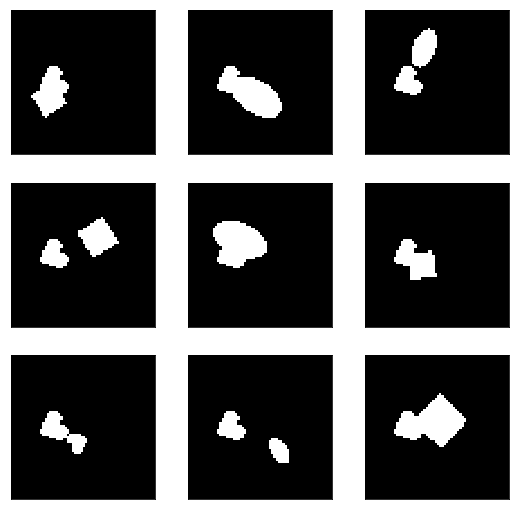

In [5]:
show_images_grid(np.squeeze(dataset), 9)

In [6]:
dataset = dataset.astype('float32')

In [7]:
dataset.shape

(2497500, 64, 64, 1)

In [8]:
TRAIN_BUF = 100000
BATCH_SIZE = 100

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(dataset[:100000]).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [10]:
class VAESprite(tf.keras.Model):
    """Same Architecture"""
    def __init__(self, latent_dim, num_object):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_object = num_object
        
        self.encoder1 = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
        ])
        
        self.encoder2 = tf.keras.Sequential([       
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=24, kernel_size=2, strides=(1, 1), activation=tf.nn.elu),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=2*2*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(2, 2, 64)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=(4, 4), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=1, strides=(1, 1), padding="SAME"),
        ])
    
    def call(self, img, is_sigmoid=False):
        """Reuse the code from the Google Example"""
        encoder1 = self.encoder1(img)
        
        # Adding x, y coordinate
        x = tf.convert_to_tensor([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])/7
        y = tf.convert_to_tensor([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])/7
        
        X, Y = tf.meshgrid(x, y)
        X, Y = tf.expand_dims(tf.cast(X, tf.float32), -1), tf.expand_dims(tf.cast(Y, tf.float32), -1)
        X, Y = tf.expand_dims(tf.cast(X, tf.float32), 0), tf.expand_dims(tf.cast(Y, tf.float32), 0)
        
        X, Y = tf.tile(X, [encoder1.shape[0], 1, 1, 1]), tf.tile(X, [encoder1.shape[0], 1, 1, 1])
        
        encoder_pos = tf.concat([encoder1, X, Y], -1)
        encoder_final = self.encoder2(encoder_pos)
        
        encoder_flatten = tf.reshape(encoder_final, (tf.shape(encoder_final)[0], 
                                                    -1, tf.shape(encoder_final)[-1]))
        
        mean, log_var = tf.split(encoder_flatten, num_or_size_splits=2, axis=-1)
        
        # Getting Analytic-KL
        kl = 0.5 * tf.reduce_sum(tf.exp(log_var) + mean**2 - 1. - log_var, axis=[-1])
        total_kl_value, total_kl_index = tf.math.top_k(kl, k=self.num_object)
        
        # Getting top 2
        top_latent_mean = tf.batch_gather(mean, total_kl_index)
        top_latent_log_var = tf.batch_gather(log_var, total_kl_index)
        
        # Getting latents for each objects 
        normal = tf.random_normal(shape=top_latent_mean.shape)
        each_latent = normal * tf.exp(top_latent_log_var * .5) + top_latent_mean
        
        # Should I do this ? 
        latents = tf.reshape(each_latent, (-1, self.latent_dim))
        decoded = self.decoder(latents)
        
        imgs = tf.reshape(decoded, (-1, self.num_object, decoded.shape[1], 
                                       decoded.shape[2], decoded.shape[3]))
        
        # Add all images 
        final_images = tf.reduce_sum(imgs, axis=1)
        return each_latent, final_images, top_latent_mean, top_latent_log_var, total_kl_index

In [11]:
latent_size = 12
object_number = 2

learning_rate = 1e-3

def get_learning_rate():
    global learning_rate
    learning_rate *= 0.9999984649444495
    return learning_rate

In [12]:
vae = VAESprite(latent_size, object_number)
optimizer = tf.train.AdamOptimizer(learning_rate=get_learning_rate)

global_step = tf.train.get_or_create_global_step()
summary_writer = tf.contrib.summary.create_file_writer(f"tmp/{experiment_name}")

saver = tf.train.Checkpoint(optimizer=optimizer,
                            model=vae,
                            optimizer_step=tf.train.get_or_create_global_step())

save_path = f"save/{experiment_name}"
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [13]:
for e in range(300):
    print(f"At epoch {e}")
    for i, img in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            tape.watch(vae.variables)

            latent, out, mean, log_var, kl_map = vae(img)
            flat_mean = tf.reshape(mean, (-1, latent_size))
            flat_log_var = tf.reshape(log_var, (-1, latent_size))

            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=out, labels=img)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
            kl_loss = 0.5 * tf.reduce_sum(tf.exp(flat_log_var) + flat_mean**2 - 1. - flat_log_var, 
                                          axis=[1])
            kl_loss = tf.reduce_sum(tf.reshape(kl_loss, (-1, object_number)), axis=1)
            loss = -tf.reduce_mean(logpx_z - kl_loss)
            
            if i % 100 == 0:
                print(f"Loss -- {loss} Current Learning Rate {learning_rate}")
                with summary_writer.as_default(), tf.contrib.summary.always_record_summaries():
                    tf.contrib.summary.scalar('Loss', loss)
                    tf.contrib.summary.image('Before', img)
                    tf.contrib.summary.image('Sample', tf.nn.sigmoid(out))
                    
        
        grad = tape.gradient(loss, vae.variables)
        global_step.assign_add(1)
        optimizer.apply_gradients(zip(grad, vae.variables))
        
    print(f"---------")
    saver.save(f"save/{experiment_name}/{experiment_name}.ckpt")

At epoch 0
tf.Tensor(2839.8462, shape=(), dtype=float32)
tf.Tensor(815.30505, shape=(), dtype=float32)
tf.Tensor(718.5691, shape=(), dtype=float32)
tf.Tensor(645.3423, shape=(), dtype=float32)
tf.Tensor(633.1487, shape=(), dtype=float32)
tf.Tensor(593.4791, shape=(), dtype=float32)
tf.Tensor(584.58093, shape=(), dtype=float32)
tf.Tensor(575.48987, shape=(), dtype=float32)
tf.Tensor(546.7737, shape=(), dtype=float32)
tf.Tensor(538.746, shape=(), dtype=float32)
---------
At epoch 1
tf.Tensor(518.69476, shape=(), dtype=float32)
tf.Tensor(494.92407, shape=(), dtype=float32)
tf.Tensor(530.2121, shape=(), dtype=float32)
tf.Tensor(488.8722, shape=(), dtype=float32)
tf.Tensor(492.69318, shape=(), dtype=float32)
tf.Tensor(496.4075, shape=(), dtype=float32)
tf.Tensor(463.3467, shape=(), dtype=float32)
tf.Tensor(481.63046, shape=(), dtype=float32)
tf.Tensor(485.11987, shape=(), dtype=float32)
tf.Tensor(473.81015, shape=(), dtype=float32)
---------
At epoch 2
tf.Tensor(451.12878, shape=(), dtype=f

KeyboardInterrupt: 

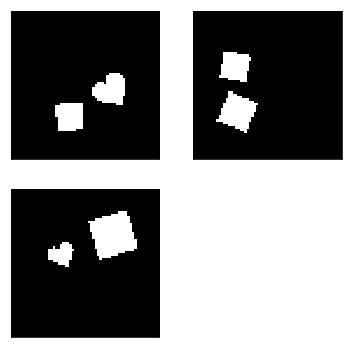

In [14]:
show_images_grid(tf.squeeze(img).numpy(), 3)

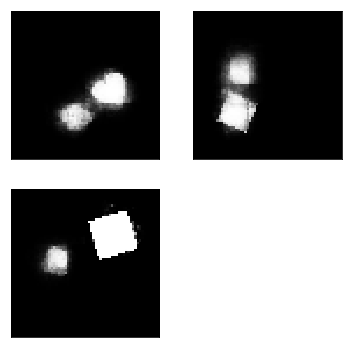

In [15]:
show_images_grid(tf.squeeze(tf.nn.sigmoid(out)).numpy(), 3)

In [16]:
def get_kl_attention_map(kl_index):
    batch_size = kl_index.shape[0]
    blank_map = np.zeros((batch_size, 25))
    for i in range(batch_size):
        blank_map[i][kl_index[i]] = 1
    return blank_map.reshape(batch_size, 5, 5)

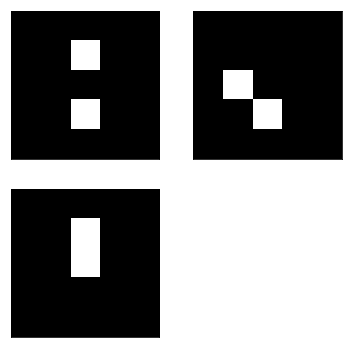

In [17]:
show_images_grid(get_kl_attention_map(kl_map), 3)